# Libraries

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from collections import defaultdict
from collections import Counter
import math
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt

# Cleaning the Data

In [2]:
#path = '/Users/domenicomattiacinque/Documents/Università/ADM2020/HW4/archive'
dataset = pd.read_csv('Reviews.csv')

In [3]:
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
dataset.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

We can see that there are null values only in the columns 'ProfileName' and 'Summary'. In the next cell er are going to fill only the summary column with empty string because for our purposes we don't need the profile name that will be dropped.

In [5]:
dataset['Summary'].fillna('', inplace=True)

In order to have a better understading of the type of product we group the column summary and text together.

In [6]:
dataset['Text'] = dataset['Summary'] + ' ' + dataset['Text'] 

We drop the column that we don't need to use for this homework.

In [7]:
dataset.drop(['ProfileName','HelpfulnessNumerator',
              'HelpfulnessDenominator','Time','Summary'],axis=1, inplace=True)

In [8]:
dataset.head()

,Id,ProductId,UserId,Score,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha..."
3,4,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...


Our task is to cluster the product so we apply a groupby on 'ProductId'.

In [10]:
df = dataset.groupby('ProductId')['Text'].apply(lambda x: ' '.join(x)).reset_index()

In [11]:
df.head()

,ProductId,Text
0,0006641040,Read it once. Read it twice. Reading Chicken S...
1,141278509X,The best drink mix This product by Archer Farm...
2,2734888454,made in china My dogs loves this chicken but i...
3,2841233731,Great recipe book for my babycook This book is...
4,7310172001,very good This product is a very health snack ...


# Text Mining
We want to cluster the products using the reviews that we can find in the column 'Text' of our dataset. In order to do this we need to represent the reviews as TF-IDF score used in the previous homework.

In [12]:
import nltk
from nltk.corpus import stopwords
import string
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

In the list of stop words we insert words that don't add information about the product they are refering to.

In [15]:
stop_words = list(stopwords.words('english'))
stop_words.extend(('br','product','http','lot','time','item','everith','someone','thing','bit','anyth','thank'))
ps = PorterStemmer()

In [16]:
#Realizing the cleaned token 
def clean_text(text):
    words = word_tokenize(text)    #tokenizing the text
    tagged = nltk.pos_tag(words)   #tag help us to understand what kind of word is 
    good_words = []                # list of cleaned words
    for word,tag in tagged:
        if tag == 'NN' or tag == 'NNS' or tag =='NNPS' or tag == 'NNP': #filter on the words
            if word.lower() not in stop_words and word.isalpha() and word.lower() not in string.punctuation:
                good_words.append(ps.stem(word).lower())
    return good_words

In [ ]:
#Cleaning the column 'Text_Words'
df['Text_Words'] = df.Text.apply(lambda x: clean_text(x))

In [31]:
#creating a vocabulary that contains every clean word of the dataset
def vocabulary(df):
    words = defaultdict(list)
    for i,el in enumerate(df['Text_Words']):
        for w in el:
            words[w].append(i)
    return words
voc = vocabulary(df)

In [32]:
#counting the ripetition of each token for each plot
df["Text_Ripetition"] = df["Text_Words"].apply(lambda x : Counter(x))

The column 'Text_Ripetition' will be used to creare the tf score, it contains the ripetition of each word in a single record.

In [33]:
df.head()

,ProductId,Text,Text_Words,Text_Ripetition
0,0006641040,Read it once. Read it twice. Reading Chicken S...,"[chicken, soup, rice, day, person, chicken, so...","{'chicken': 19, 'soup': 35, 'rice': 21, 'day':..."
1,141278509X,The best drink mix This product by Archer Farm...,"[drink, mix, product, archer, farm, drink, mix...","{'drink': 2, 'mix': 2, 'product': 1, 'archer':..."
2,2734888454,made in china My dogs loves this chicken but i...,"[dog, chicken, product, china, chicken, produc...","{'dog': 3, 'chicken': 2, 'product': 3, 'china'..."
3,2841233731,Great recipe book for my babycook This book is...,"[great, book, babycook, book, ingredi, store, ...","{'great': 1, 'book': 3, 'babycook': 1, 'ingred..."
4,7310172001,very good This product is a very health snack ...,"[product, health, snack, pup, beef, liver, tri...","{'product': 78, 'health': 1, 'snack': 11, 'pup..."


### Calculating the tf score for each record

In [34]:
def tf_i(text):
    tot_token = 0
    for k, v in text.items():
        tot_token += v #numbers of total tokens in the plot
    tf = {}
    for token, rip in text.items():#the values in this dictionary are the ripetition of that specific token
        tf[token] = round(rip / tot_token,4)
    return tf 

In [35]:
tf = []
for i in range(len(df['Text_Ripetition'])):
    tf.append(tf_i(df["Text_Ripetition"][i])) #applying the previous function to each plot
df["Tf"] = tf #adding the column tf to the dataset

In [36]:
df.head()

,ProductId,Text,Text_Words,Text_Ripetition,Tf
0,0006641040,Read it once. Read it twice. Reading Chicken S...,"[chicken, soup, rice, day, person, chicken, so...","{'chicken': 19, 'soup': 35, 'rice': 21, 'day':...","{'chicken': 0.0252, 'soup': 0.0464, 'rice': 0...."
1,141278509X,The best drink mix This product by Archer Farm...,"[drink, mix, product, archer, farm, drink, mix...","{'drink': 2, 'mix': 2, 'product': 1, 'archer':...","{'drink': 0.08, 'mix': 0.08, 'product': 0.04, ..."
2,2734888454,made in china My dogs loves this chicken but i...,"[dog, chicken, product, china, chicken, produc...","{'dog': 3, 'chicken': 2, 'product': 3, 'china'...","{'dog': 0.1579, 'chicken': 0.1053, 'product': ..."
3,2841233731,Great recipe book for my babycook This book is...,"[great, book, babycook, book, ingredi, store, ...","{'great': 1, 'book': 3, 'babycook': 1, 'ingred...","{'great': 0.0667, 'book': 0.2, 'babycook': 0.0..."
4,7310172001,very good This product is a very health snack ...,"[product, health, snack, pup, beef, liver, tri...","{'product': 78, 'health': 1, 'snack': 11, 'pup...","{'product': 0.0257, 'health': 0.0003, 'snack':..."


### Creating idf score for each token

In [37]:
idf = {}
for el in df['Text_Words']:   
    for token in el:
         idf.update({ token : round(math.log(len(df)/ len(voc[token]),3))})  #applying the formula for each token 

In [38]:
# Creating a vocabulary that as keys as the word and as values its index
def vocabulary_words(df):
    words = dict()
    i = 0
    for el in tqdm(df['Text_Words']):
        for w in el:
            if w not in words.keys():
                words[w] = i
                i += 1
    return words

In [39]:
voc_words = vocabulary_words(df)

100%|██████████| 74258/74258 [00:01<00:00, 47052.28it/s]


### Calculating TF-IDF score for each token

In [40]:
def score(dictionary):
    v = [0]*(len(voc_words))
    for word in dictionary.keys():
        v[voc_words[word]] = dictionary[word]*idf[word]
    return v

## Dimensionality Reduction usign SVD

In order to use SVD method we need to create a sparse matrix, for this aim we use the library scipy and sklearn

In [41]:
from scipy.sparse import lil_matrix

matrix = lil_matrix((len(df), len(voc_words)), dtype=np.float)
for i in tqdm(range(len(df["Tf"]))):
    matrix[i] = np.array(score(df["Tf"][i]))

100%|██████████| 74258/74258 [10:01<00:00, 123.42it/s]


In [42]:
from scipy.sparse import csr_matrix

matrix = csr_matrix(matrix)

In [43]:
from sklearn.decomposition import TruncatedSVD

In [45]:
svd = TruncatedSVD(n_components=2500, random_state=42)
svd.fit(matrix)

TruncatedSVD(n_components=2000, random_state=42)

we picked a number of components that retain about 60% of the variance

In [46]:
print(svd.explained_variance_ratio_.sum())

0.5969942033804378


In [47]:
svd_matrix = svd.transform(matrix)

In [48]:
svd_matrix.shape

(74258, 2000)

## Implement KMeans from scratch
### Step 1
Random inizialization of the k representative points
### Step 2
Find the cluster $C_i$ defined as $\{x : \parallel x-\mu_i\parallel \leq \parallel x-\mu_j\parallel \forall j\ne i\}  \forall i=1..k$
### Step 3 
Find $\mu_i$ which is defined as $\frac{1}{|C_i|} \sum_{x\in C_i} x \;\; \forall i=1..k$
<hr>
Repeat step 2 and step 3 until <b>convergence</b>.

### Convergence
We stop when the clusters don't change from the previous iteration.

### Step 4 
Elbow method to choose the number of clusters k 

### Our KMeans

In [49]:
import random

In [50]:
def euclidian_dist(x,y):
    return np.linalg.norm(x-y)

In [92]:
def OurKMeans(k, matrix):
    #Step 1. Choosing k random representatives
    representatives_idx = random.sample(range(1, len(matrix)), k)  #Chosing the initial representatives
    new_representatives =  []
    for i in range(k):
        new_representatives.append(matrix[representatives_idx[i]])
    representatives = []
    
    run = True
    
    while run:
        representatives = new_representatives
        
        # Creating the clusters
        clusters = {i: [] for i in range(k)}  # Empty dictionary for each cluster with list as value 
        i_clusters = {i: [] for i in range(k)}
        
        #Step 2. Computing distances and choosing 
        for ind, point in enumerate(matrix):
            dist_xmu = []      # Distance between the point and the representatives for each representative
            for i in range(k): 
                dist_xmu.append(euclidian_dist(representatives[i], point))
            nearest_representative = dist_xmu.index(min(dist_xmu))
            clusters[nearest_representative].append(point) #Put the point in the cluster with the minimum distance
            i_clusters[nearest_representative].append(ind)
            
        #Step 3. Selecting new representatives
        new_representatives = []
        for i in range(k):
            run = False
            new_val = np.sum(clusters[i],axis=0)/len(clusters[i])
            new_representatives.append(new_val)
        #Convergence statement
        for i in range(len(representatives)):
            if np.any(representatives[i] != new_representatives[i]):
                run = True
                
    return clusters, new_representatives, i_clusters

### Elbow Method 

The elbow method allows us to choose the number of cluster k choosing the elbow point in the plot that has the number of cluster as x axis and the inertia as y axis. <br>
First of all we implement the function that calculate the inertia which is defined as: <hr>
<center>$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2) $ </center>
where: <br>
- $\mu_j$ are the centroids for j in range (1,k) <br>
- $x_i$ are the points to cluster for i in range (0,n)

In [89]:
def inertia(matrix, centroid, k):
    sq_norms = [] #consideranting the norms of xi - muj where i is fixed and j is in range(k)
    sum_ = 0
    for i in range(len(matrix)):
        sq_norms = []
        for j in range(k):
            sq_norm = euclidian_dist(matrix[i],centroid[j])**2 # squared norm between xi and muj
            sq_norms.append(sq_norm) #saving the result in the j-th position of sq_norms array
        min_sq_norm = min(sq_norms) #considering the minimum norm
        sum_ += min_sq_norm
    return sum_ #return inertia

In [93]:
elbow = []
for k in tqdm(range(1, 10)):
    clusters, representatives, i_clusters = OurKMeans(k, svd_matrix)
    inertia_ = inertia(svd_matrix, representatives, k) 
    elbow.append(inertia_)

100%|██████████| 9/9 [15:11<00:00, 101.25s/it]


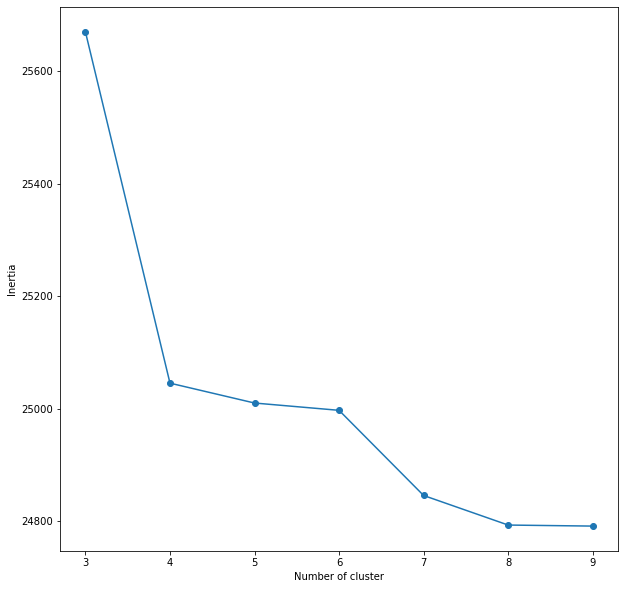

In [77]:
plt.figure(figsize = (10, 10))
plt.plot(range(3,10), elbow[2:])
plt.scatter(range(3,10), elbow[2:])
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

From the previous plot we fix k equals to 7

In [ ]:
our_KMeans = ourKMeans(7, svd_matrix)

## KMeans ++
To implement KMeans++ and the elbow method we use sklearn library

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
elbow = {}
for k in tqdm(range(3,10)):
    elbow_model = KMeans (n_clusters = k, init = 'k-means++')
    elbow_model.fit_predict(svd_matrix)
    elbow[k] = elbow_model.inertia_

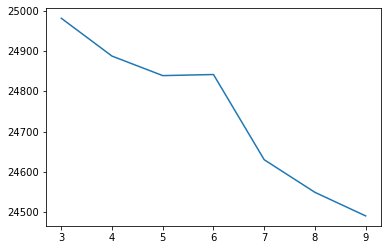

In [69]:
plt.plot(list(elbow.keys()), list(elbow.values()))

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0, init='k-means++').fit(matrix)

### Comparison 

As first result we can observe that the elbow method return the same number of cluster for both the algorithms.
?cluster
?inertia
?initial centroid

## Cluster Analysis

We create another column to the dataset which contains the cluster number the record belongs to, this is a possible solution to answer at the final questions.

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0, init='k-means++').fit(matrix)

In [54]:
labels = kmeans.labels_

In [55]:
df['cluster'] = labels

In [56]:
df['Text_Words'] = df.Text_Words.apply(lambda x: ' '.join(x)) 

In [57]:
df.head()

,ProductId,Text,Text_Words,Text_Ripetition,Tf,cluster
0,0006641040,Read it once. Read it twice. Reading Chicken S...,chicken soup rice day person chicken soup word...,"{'chicken': 19, 'soup': 35, 'rice': 21, 'day':...","{'chicken': 0.0252, 'soup': 0.0464, 'rice': 0....",4
1,141278509X,The best drink mix This product by Archer Farm...,drink mix product archer farm drink mix packet...,"{'drink': 2, 'mix': 2, 'product': 1, 'archer':...","{'drink': 0.08, 'mix': 0.08, 'product': 0.04, ...",4
2,2734888454,made in china My dogs loves this chicken but i...,dog chicken product china chicken product usa ...,"{'dog': 3, 'chicken': 2, 'product': 3, 'china'...","{'dog': 0.1579, 'chicken': 0.1053, 'product': ...",4
3,2841233731,Great recipe book for my babycook This book is...,great book babycook book ingredi store recip b...,"{'great': 1, 'book': 3, 'babycook': 1, 'ingred...","{'great': 0.0667, 'book': 0.2, 'babycook': 0.0...",4
4,7310172001,very good This product is a very health snack ...,product health snack pup beef liver trick trea...,"{'product': 78, 'health': 1, 'snack': 11, 'pup...","{'product': 0.0257, 'health': 0.0003, 'snack':...",4


### Identify the kind of products in the cluster

In [58]:
df_cluster = df.groupby('cluster')['Text_Words'].apply(lambda x: ' '.join(x)).reset_index()

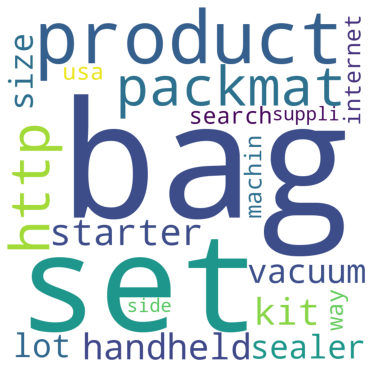

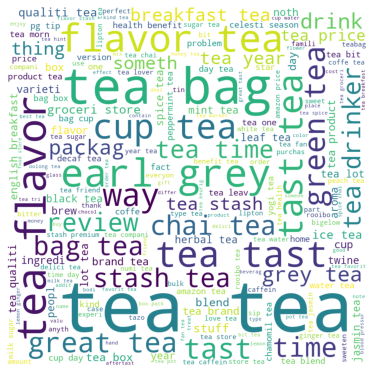

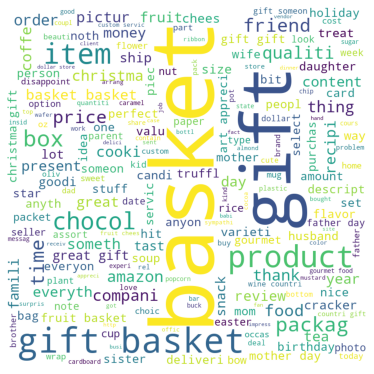

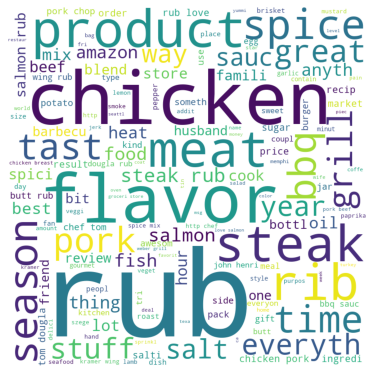

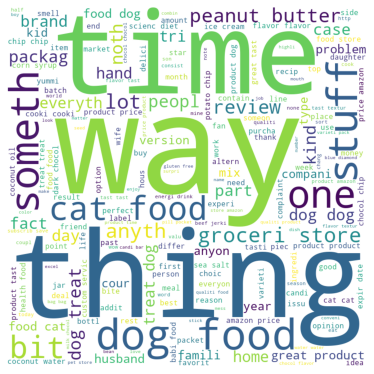

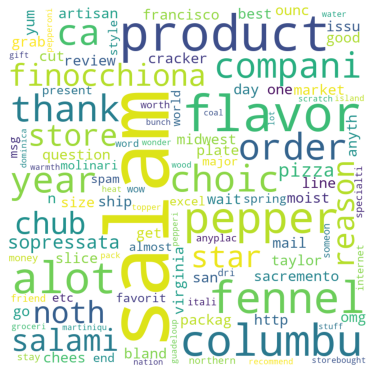

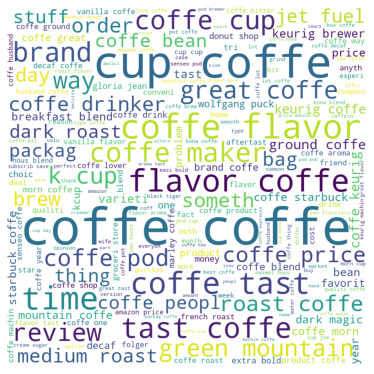

In [60]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

for i in range(len(df_cluster)):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stop_words, 
                    min_font_size = 10).generate(df_cluster.iloc[i].Text_Words) 

    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

Through these plots we can suppose that the clusters contain the following product:
- Cluster 0 : is a single review that isn't about food but about eletronics
- Cluster 1 : about tea
- Cluster 2 : food basket to use as a gift
- Cluster 3 : about meat and sauces
- Cluster 4 : animal food
- Cluster 5 : salami
- Cluster 6 : coffee

### Provide the number of product in each cluster

In [61]:
df_cluster2 = df.groupby('cluster')['ProductId'].count().reset_index()

In [62]:
df_cluster2

,cluster,ProductId
0,0,1
1,1,5302
2,2,275
3,3,168
4,4,64234
5,5,5
6,6,4273


We can observe that the product aren't equally distributed in the clusters. <br>
The majority of product are in the cluster about pet food, followed by tea and coffe. We can conclude that most of the people by on amazon these kind of product rather than dried meat and salami.

### Compute the reviews' score distribution in each cluste

In [74]:
cluster_dict = defaultdict(list)

for row in df:
    cluster_dict[row.cluter].append(row.ProductId)

ProductId


In [79]:
comb = df[['ProductId','cluster']].set_index('ProductId').T.to_dict()

In [83]:
dataset['cluster'] = dataset.ProductId.apply(lambda x: comb[x]['cluster'])

In [86]:
dataset

,Id,ProductId,UserId,Score,Text,cluster
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...,4
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...,4
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha...",4
3,4,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...,4
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...,4
...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,5,Will not do without Great for sesame chicken.....,4
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,2,disappointed I'm disappointed with the flavor....,4
568451,568452,B004I613EE,A121AA1GQV751Z,5,Perfect for our maltipoo These stars are small...,4
568452,568453,B004I613EE,A3IBEVCTXKNOH,5,Favorite Training and reward treat These are t...,4


In [85]:
dataset.groupby('cluster')['Score'].mean()

cluster
0    1.000000
1    4.331535
2    3.804220
3    4.665914
4    4.173286
5    4.800000
6    4.152662
Name: Score, dtype: float64

The mean score is similar among the cluster except for the first one and the third one. The first cluster is made up by a single rewies with a score equal to 1.

In [ ]:
#TEST 

### Unique users writing reviews in each cluster

In [88]:
dataset.groupby('cluster')['UserId'].nunique()

cluster
0         1
1     22730
2       835
3       356
4    216745
5        10
6     29735
Name: UserId, dtype: int64

In the second column we show the number of users that have written a reviews for a product in the related cluster.